# Test the pipeline with the GRU Model.

In [1]:
import os
import numpy as np
import torch
import cv2
from torch.utils.data import DataLoader
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm

# Get the path of the project root
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))

# Add the project root to sys.path if it is not already in sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# Import the ImageSequenceDataset and create_dataloader from the pipeline module
from seismogram_extraction.pipeline import evaluate_filter, create_dataloader
from seismogram_extraction.models.rnn_gru import RNN_GRU, train_rnn

import torch.multiprocessing as mp
mp.set_start_method('spawn')  # or 'forkserver' if available

from collections import defaultdict

plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.titlesize'] = 12


In [2]:
sources_eval_sines_2_curves = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-00",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-06",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-11",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-17",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-22",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-28",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-33",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-39",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-44",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-50"]

sources_eval_resampled_2_curves = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-00",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-06",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-11",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-17",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-22",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-28",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-33",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-39",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-44",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-50"]

sources_eval_resampled_5_curves = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-0",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-055",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-11",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-17",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-22",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-28",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-33",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-38",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-44",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-5"]

sources_eval_sines_5_curves = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-00",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-06",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-11",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-17",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-22",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-28",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-33",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-39",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-44",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-50"]

In [3]:
overlaps = np.array([0.00, 0.06, 0.11, 0.17, 0.22, 0.28, 0.33, 0.39, 0.44, 0.50])
success = np.zeros((len(overlaps), 6, 2)) # Shape (overlaps, num_methods, 2) 2 for sines and resampled

In [4]:
meanlines_2 = np.array([125.0, 275.0])

Training on: D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-00
Epoch 0: Train Loss = 747.9467, Eval Loss = 743.8777
Epoch 1: Train Loss = 749.3458, Eval Loss = 743.8710
Epoch 2: Train Loss = 747.4678, Eval Loss = 743.8667
Epoch 3: Train Loss = 748.3582, Eval Loss = 743.8655
Epoch 4: Train Loss = 749.3438, Eval Loss = 743.8619
Epoch 5: Train Loss = 746.9269, Eval Loss = 743.8602
Epoch 6: Train Loss = 749.2663, Eval Loss = 743.8582
Epoch 7: Train Loss = 747.9350, Eval Loss = 743.8574
Epoch 8: Train Loss = 747.9346, Eval Loss = 743.8568
Epoch 9: Train Loss = 747.9665, Eval Loss = 743.8552


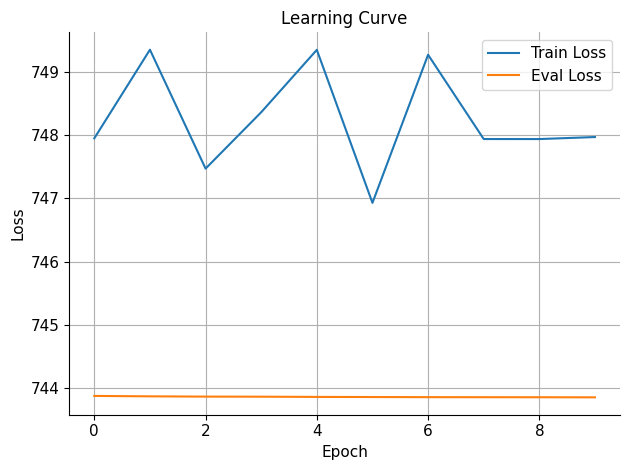

In [5]:
a_0 = 20
omega_0 = np.pi/2
phi_0 = 0
batch_size = 5
epochs = 10
N_traces = 2
selected = r"\data_2_traces"
meanlines = meanlines_2
sources_train = [
    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction" + selected + r"\sines_long\overlap_0-00"
]
source_eval = [

]

# --- Model, Optimizer, Training Loop ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNN_GRU().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for train_source in sources_train:
    print("Training on:", train_source)
    image_folder = os.path.join(train_source, "signals")
    gt_folder = os.path.join(train_source, "ground_truth")
    train_loader, val_loader = create_dataloader(image_folder, gt_folder, batch_size=batch_size, split=True)

    loss = train_rnn(model, train_loader, val_loader, optimizer, torch.tensor(meanlines), X_0=torch.tensor([a_0, omega_0, phi_0]), device=device, epochs=epochs)	


In [6]:
# --- Evaluation Phase ---
success_threshold = 10.0
success_rates = []

sources_eval = sources_eval_sines_2_curves + sources_eval_resampled_2_curves

for source in sources_eval:
    print("Evaluating:", source)
    image_folder_path = os.path.join(source, "signals")
    GTs_folder_path = os.path.join(source, "ground_truth")

    output_folder_path = os.path.join(source, f"GRU_Ntraces{N_traces}_utv1")
    os.makedirs(output_folder_path, exist_ok=True)

    average_rmse, rmse_std, curve_rmses = evaluate_rnn_tracker(
        image_folder_path, GTs_folder_path, output_folder_path,
        model, batch_size=batch_size, step=1,
        a_0=a_0, omega_0=omega_0, phi_0=phi_0, forum=True
    )

    success_rate = np.mean(np.array(curve_rmses) <= success_threshold) * 100
    success_rates.append(success_rate)

print("Success rate:", success_rates)

Evaluating: D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines_long\overlap_0-00


NameError: name 'evaluate_rnn_tracker' is not defined